In [ ]:
!pip install git+https://github.com/salute-developers/GigaAM.git
!pip install datasets==3.6.0

# Augmentations

In [ ]:
import copy
import math
import os
import random
import subprocess

import datasets
import gigaam
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import sentencepiece
import soundfile
import torch
import torchaudio
from torch import nn

plt.style.use("dark_background")

In [ ]:
ds = datasets.load_dataset("fsicoli/common_voice_21_0", "ru", split="validation")

In [ ]:
N_SAMPLES = 100
SEED = 42
SAMPLE_RATE = 16_000

ds = ds.shuffle(SEED).select(range(N_SAMPLES))

In [5]:
ds[0]

{'client_id': 'd60be9afbe1f569dea4c3f8a62af44b40d3cceb1f8e398841fdb5293064af710f2a4a214c62ac92df08f1628529220f7583c490c7f1aa7b1fb98f802ded1cb76',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/d3220cac63e843806aff9251a752074dfd6ccd39fa1a35cd325f36b5b629167a/ru_dev_0/common_voice_ru_36510056.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/d3220cac63e843806aff9251a752074dfd6ccd39fa1a35cd325f36b5b629167a/ru_dev_0/common_voice_ru_36510056.mp3',
  'array': array([ 5.68434189e-14, -1.42108547e-13, -3.55271368e-13, ...,
          3.57123281e-06,  7.53839231e-06,  3.23578570e-06]),
  'sampling_rate': 48000},
 'sentence': 'А я хотел к вам посылать.',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'fourties',
 'gender': 'male_masculine',
 'accent': '',
 'locale': 'ru',
 'segment': '',
 'variant': ''}

In [ ]:
ds = ds.cast_column("audio", datasets.Audio(sampling_rate=SAMPLE_RATE))

In [ ]:
gigaam_ctc_v2 = gigaam.load_model("v2_ctc", fp16_encoder=False, device="cpu")

100%|███████████████████████████████████████| 444M/444M [00:27<00:00, 17.0MiB/s]
/usr/local/lib/python3.12/dist-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

А я хотел к вам посылать.


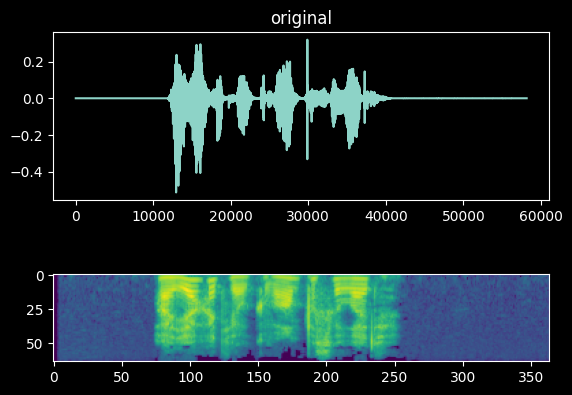

In [ ]:
@torch.no_grad()
def get_gigaam_spectrogram(wav: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
    wav = wav.astype(np.float32)
    device = next(gigaam_ctc_v2.encoder.parameters()).device

    wav_tensor = torch.frombuffer(wav, dtype=torch.float32).unsqueeze(0)
    wav_length = torch.full([1], wav_tensor.shape[-1])

    spectrogram, spec_len = gigaam_ctc_v2.preprocessor(
        wav_tensor.to(device),
        wav_length.to(device),
    )  # B x n_mels x T

    return spectrogram.cpu(), spec_len.cpu()


def plot_wav_with_features(
    wav: np.ndarray, spectrogram: np.ndarray, title: str | None = None
) -> None:

    plt.subplot(211)
    if title:
        plt.title(title)
    plt.plot(wav)
    plt.subplot(212)
    plt.imshow(spectrogram)
    plt.show()


for row in ds:
    print(row["sentence"])
    wav = row["audio"]["array"]
    spectrogram, spec_len = get_gigaam_spectrogram(wav)
    plot_wav_with_features(wav, spectrogram[0].numpy(), title="original")
    break

In [ ]:
class SpecAugment(torch.nn.Module):
    def __init__(
        self, time_mask_p=0.05, time_mask_param=30, freq_mask_param=15, num_masks=2
    ):
        super().__init__()
        self.time_mask_param = time_mask_param
        self.freq_mask_param = freq_mask_param
        self.num_masks = num_masks
        self.time_mask_p = time_mask_p

    def forward(self, mel: torch.Tensor) -> torch.Tensor:
        x = mel.clone()
        tm = torchaudio.transforms.TimeMasking(self.time_mask_param)
        fm = torchaudio.transforms.FrequencyMasking(self.freq_mask_param)
        for _ in range(self.num_masks):
            x = fm(x)
            if random.random() < self.time_mask_p:
                x = tm(x)
        return x


@torch.inference_mode()
def transcribe(spectrogram: torch.Tensor, spec_len: torch.Tensor) -> str:
    device = next(gigaam_ctc_v2.encoder.parameters()).device
    encoded, encoded_len = gigaam_ctc_v2.encoder(
        spectrogram.to(device), spec_len.to(device)
    )
    out = gigaam_ctc_v2.decoding.decode(gigaam_ctc_v2.head, encoded, encoded_len)
    return out[0]

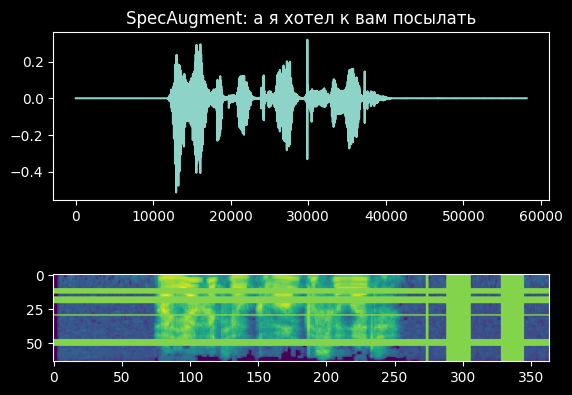

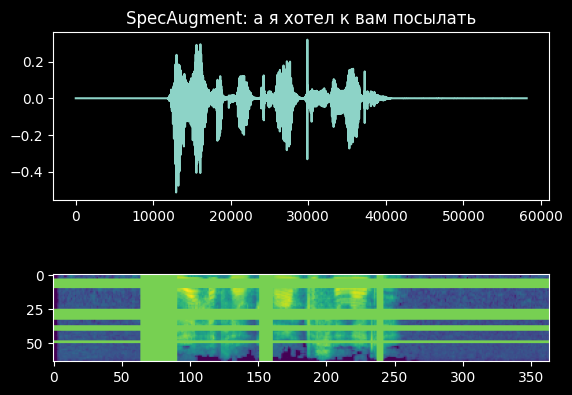

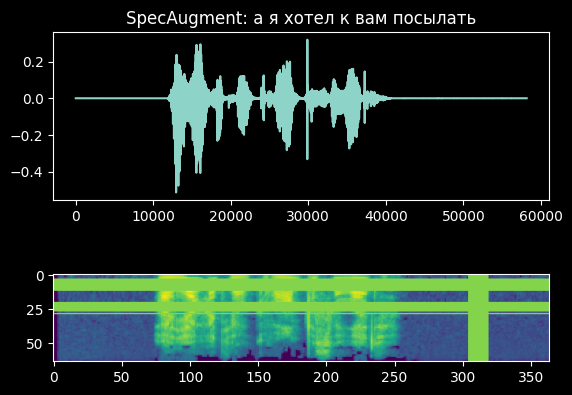

In [11]:
augmentor = SpecAugment(num_masks=5, time_mask_p=0.25, freq_mask_param=10)

for _ in range(3):
    augmented_spec = augmentor(spectrogram)
    hyp = transcribe(augmented_spec, spec_len)
    plot_wav_with_features(wav, augmented_spec[0].numpy(), title=f"SpecAugment: {hyp}")

In [ ]:
def opus_codec(wav: np.ndarray, sr: int, bitrate: str = "16k") -> np.ndarray:
    tmp_in = "_tmp_in.wav"
    tmp_out = "_tmp_out.wav"
    tmp_opus = "_tmp.opus"

    wav_int16 = (wav * 32767).astype(np.int16)

    soundfile.write(tmp_in, wav_int16, sr)

    try:
        subprocess.run(
            ["ffmpeg", "-i", tmp_in, "-c:a", "libopus", "-b:a", bitrate, tmp_opus],
            check=True,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
        )
        subprocess.run(
            ["ffmpeg", "-i", tmp_opus, "-ar", str(sr), tmp_out],
            check=True,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
        )
        y, _ = soundfile.read(tmp_out)
    finally:
        for p in [tmp_in, tmp_out, tmp_opus]:
            if os.path.exists(p):
                os.remove(p)
    return y

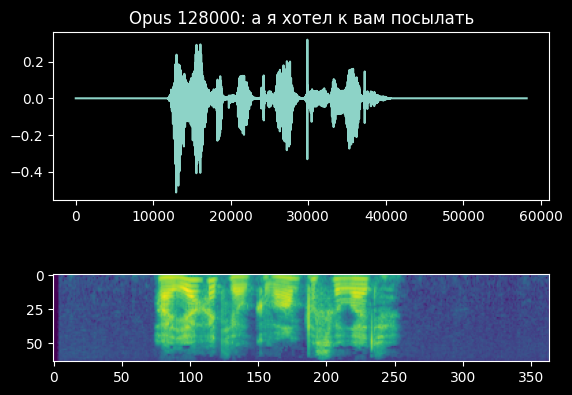

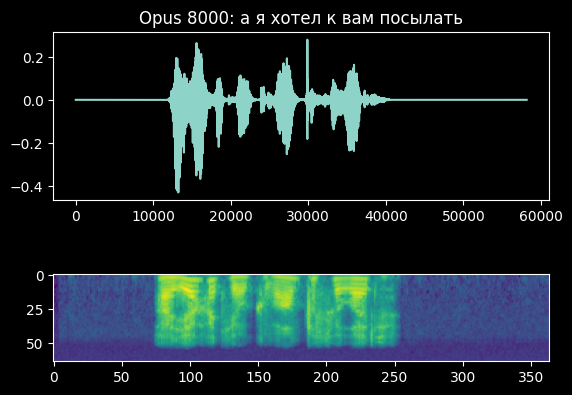

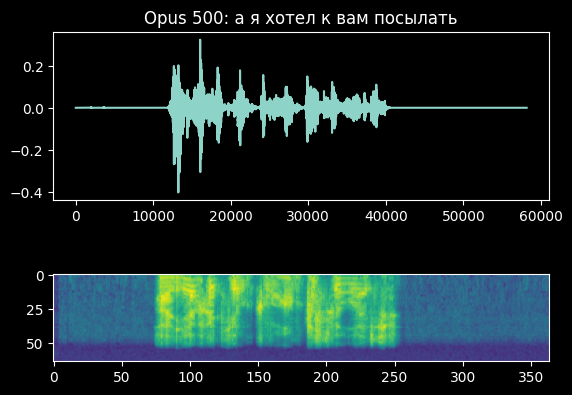

In [ ]:
for bitrate in ("128000", "8000", "500"):
    augmented_wav = opus_codec(wav, sr=SAMPLE_RATE, bitrate=bitrate)
    ipd.display(ipd.Audio(augmented_wav, rate=SAMPLE_RATE))
    augmented_spec, augmented_spec_len = get_gigaam_spectrogram(augmented_wav)
    hyp = transcribe(augmented_spec, augmented_spec_len)
    plot_wav_with_features(
        augmented_wav, augmented_spec[0].numpy(), title=f"Opus {bitrate}: {hyp}"
    )

In [ ]:
class NoiseAugment:
    def __init__(
        self,
        noise_ds_params: dict,
        target_snr_db: float = 10.0,
        sample_rate: int = 16_000,
        max_files: int = 100,
    ):
        super().__init__()
        self.target_snr_db = target_snr_db
        self.noises = [
            row["audio"]["array"]
            for row in (
                datasets.load_dataset(**noise_ds_params)
                .cast_column("audio", datasets.Audio(sampling_rate=sample_rate))
                .shuffle()
                .select(range(max_files))
            )
        ]

    def __call__(self, wav: np.ndarray) -> np.ndarray:
        noise = random.choice(self.noises)
        if len(noise) < len(wav):
            reps = math.ceil(len(wav) / len(noise))
            noise = np.tile(noise, reps)
        start = random.randint(0, len(noise) - len(wav))
        noise = noise[start : start + len(wav)]

        s_energy = np.mean(wav**2, dtype=np.float64) + 1e-12
        n_energy = np.mean(noise**2, dtype=np.float64) + 1e-12
        snr_linear = 10 ** (self.target_snr_db / 10)
        noise_scaled = noise * math.sqrt(s_energy / (snr_linear * n_energy))
        mixed = wav + noise_scaled

        return mixed

In [ ]:
# noise_ds_params = {
#     "path": "FluidInference/musan",
#     "split": "train",
# }


noise_ds_params = {
    "path": "fsicoli/common_voice_21_0",
    "name": "ky",
    "split": "other",
}

augmentor = NoiseAugment(noise_ds_params, target_snr_db=0)

for target_snr_db in (10, 5, 1):
    augmentor.target_snr_db = target_snr_db
    augmented_wav = augmentor(wav)
    ipd.display(ipd.Audio(augmented_wav, rate=SAMPLE_RATE))
    augmented_spec, augmented_spec_len = get_gigaam_spectrogram(augmented_wav)
    hyp = transcribe(augmented_spec, augmented_spec_len)
    plot_wav_with_features(
        augmented_wav,
        augmented_spec[0].numpy(),
        title=f"Noise SNR={target_snr_db}: {hyp}",
    )

# EncoderDecoder ASR Model

In [ ]:
VOCAB = 128
SPM_PREFIX = "spm_ky"
LANG = "ky"
DATASET = "fsicoli/common_voice_21_0"
SPLIT = "train+validation[:2%]"

if not os.path.exists(f"{SPM_PREFIX}.model"):

    ds = datasets.load_dataset(DATASET, LANG, split=SPLIT)

    ds_txt = ds.select_columns(["sentence"])
    with open("ky_corpus.txt", "w", encoding="utf-8") as f:
        for s in ds_txt["sentence"]:
            f.write(s.strip() + "\n")

    sentencepiece.SentencePieceTrainer.train(
        input="ky_corpus.txt",
        model_prefix=SPM_PREFIX,
        vocab_size=VOCAB,
        model_type="bpe",
        character_coverage=1.0,
        bos_id=1,
        eos_id=2,
        pad_id=3,
        unk_id=0,
    )

sp = sentencepiece.SentencePieceProcessor(model_file=f"{SPM_PREFIX}.model")
PAD, BOS, EOS = 3, 1, 2

ds = datasets.load_dataset(DATASET, LANG, split=SPLIT).cast_column(
    "audio", datasets.Audio(sampling_rate=SAMPLE_RATE)
)


def encode_text(s: str) -> torch.Tensor:
    ids = [BOS] + sp.encode(s or "") + [EOS]
    return torch.tensor(ids, dtype=torch.long)


def collate_fn(batch):
    features, features_length, targets, targets_length = [], [], [], []

    for ex in batch:
        wav = ex["audio"]["array"]
        spec, spec_len = get_gigaam_spectrogram(wav)
        text = encode_text(ex.get("sentence", ""))
        features.append(spec[0].T)
        features_length.append(spec_len)
        targets.append(text)
        targets_length.append(text.size(0))

    features_padded = torch.nn.utils.rnn.pad_sequence(
        features, batch_first=True
    ).permute(0, 2, 1)
    targets_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    return (
        features_padded,
        torch.Tensor(features_length).long(),
        targets_padded.long(),
        torch.Tensor(targets_length).long(),
    )


loader = torch.utils.data.DataLoader(
    ds, batch_size=8, shuffle=True, collate_fn=collate_fn
)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.pe = torch.nn.Parameter(pe, requires_grad=False)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


class DecoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, n_heads, dim_ff, dropout=0.0, batch_first: bool = True):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=batch_first
        )
        self.cross_attn = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=batch_first
        )
        self.lin1 = nn.Linear(d_model, dim_ff)
        self.lin2 = nn.Linear(dim_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.do1 = nn.Dropout(dropout)
        self.do2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.act = nn.GELU()

    def forward(
        self,
        x,
        mem,
        tgt_mask,
        tgt_pad_mask,
        mem_pad_mask,
        need_weights=False,
        average_attn=True,
    ):
        # self-attn
        sa, _ = self.self_attn(
            x,
            x,
            x,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_pad_mask,
            need_weights=False,
        )
        x = self.norm1(x + self.do1(sa))
        # cross-attn
        ca, attn = self.cross_attn(
            x,
            mem,
            mem,
            key_padding_mask=mem_pad_mask,
            need_weights=need_weights,
            average_attn_weights=average_attn,
        )
        x = self.norm2(x + self.do2(ca))
        # FFN
        y = self.lin2(self.dropout(self.act(self.lin1(x))))
        x = self.norm3(x + y)
        return x, attn


class TransformerDecoder(nn.Module):
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        embedding_dim: int,
        n_layers: int,
        tokenizer_path: str,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.tokenizer = sentencepiece.SentencePieceProcessor(model_file=tokenizer_path)

        self.embedding = nn.Embedding(self.tokenizer.vocab_size(), embedding_dim)
        self.pos_embedding = PositionalEncoding(embedding_dim, dropout=dropout)

        layer = DecoderLayerWithAttn(
            embedding_dim,
            n_heads,
            d_model,
            dropout,
            batch_first=True,
        )
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layers)])

        self.out = nn.Linear(embedding_dim, self.tokenizer.vocab_size())

    def forward(
        self,
        encoded: torch.Tensor,
        target: torch.Tensor,
        encoded_pad_mask: torch.Tensor | None = None,
        target_mask: torch.Tensor | None = None,
        target_pad_mask: torch.Tensor | None = None,
        return_attn: bool = False,
    ) -> tuple[torch.Tensor, list[torch.Tensor]]:
        emb = self.pos_embedding(self.embedding(target))
        out = emb
        attn_list = []
        for layer in self.layers:
            out, attn = layer(
                out,
                encoded,
                target_mask,
                target_pad_mask,
                encoded_pad_mask,
                need_weights=return_attn,
                average_attn=True,
            )
            if return_attn:
                attn_list.append(attn)
        out = self.out(out)
        return (out, attn_list)


class EncoderDecoder(nn.Module):
    def __init__(self, conf: dict):
        super().__init__()

        self.encoder = gigaam.load_model(
            conf["encoder"]["name"], fp16_encoder=False
        ).encoder
        self.decoder = TransformerDecoder(**conf["decoder"])
        self.projector = nn.Linear(
            conf["encoder"]["d_model"], self.decoder.embedding.embedding_dim
        )

        self.loss = nn.CrossEntropyLoss(reduction="none")

    @staticmethod
    def make_attention_mask(length: torch.Tensor) -> torch.Tensor:
        max_len = int(length.max().item())
        return torch.triu(
            torch.ones((max_len, max_len), device=length.device), diagonal=1
        ) * (-10000.0)

    @staticmethod
    def make_pad_mask(length: torch.Tensor) -> torch.Tensor:
        max_len = int(length.max().item())
        return torch.arange(0, max_len, device=length.device) < length.unsqueeze(1)

    def forward(
        self,
        features: torch.Tensor,
        features_len: torch.Tensor,
        targets: torch.Tensor,
        target_len: torch.Tensor,
        return_attn: bool = False,
    ) -> tuple[torch.Tensor, list[torch.Tensor]] | torch.Tensor:

        encoded, encoded_len = self.encoder(features, features_len)
        encoded = encoded.permute(0, 2, 1)
        encoded = self.projector(encoded)
        encoded_pad_mask = self.make_pad_mask(encoded_len)

        targets_outputs = targets[:, 1:]  # without bos
        targets_inputs = targets[:, :-1]  # without eos / last pad token
        target_len -= 1

        target_pad_mask = self.make_pad_mask(target_len)
        target_mask = self.make_attention_mask(target_len)

        logits, attn_list = self.decoder(
            encoded=encoded,
            encoded_pad_mask=~encoded_pad_mask,
            target=targets_inputs,
            target_mask=target_mask,
            target_pad_mask=~target_pad_mask,
            return_attn=return_attn,
        )

        loss = self.loss(logits.transpose(1, 2), targets_outputs)
        loss = (loss * target_pad_mask).sum() / target_pad_mask.sum()

        return (loss, attn_list) if return_attn else loss

/usr/local/lib/python3.12/dist-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cpu")
/usr/lo

step 1: loss 5.046
step 2: loss 4.855
step 3: loss 4.679
step 4: loss 4.562
step 5: loss 4.520
step 6: loss 4.549
step 7: loss 4.416
step 8: loss 4.403
step 9: loss 4.333
step 10: loss 4.349
step 11: loss 4.365
step 12: loss 4.298
step 13: loss 4.152
step 14: loss 4.314
step 15: loss 4.353
step 16: loss 4.285
step 17: loss 4.271
step 18: loss 4.275
step 19: loss 4.111
step 20: loss 4.201


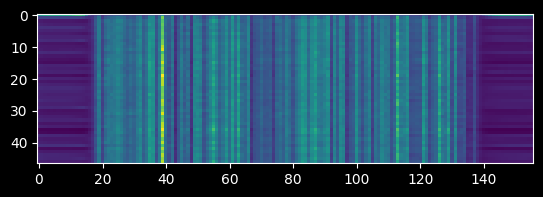

step 21: loss 4.083
step 22: loss 4.110
step 23: loss 4.101
step 24: loss 4.107
step 25: loss 4.023
step 26: loss 4.040
step 27: loss 4.014
step 28: loss 4.095
step 29: loss 3.950
step 30: loss 4.006
step 31: loss 3.934
step 32: loss 3.879
step 33: loss 3.746
step 34: loss 3.900
step 35: loss 3.839
step 36: loss 3.888
step 37: loss 3.859
step 38: loss 3.841
step 39: loss 3.880
step 40: loss 3.813


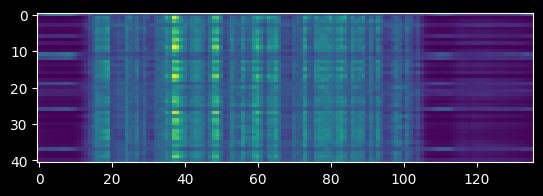

step 41: loss 3.765
step 42: loss 3.716
step 43: loss 3.725
step 44: loss 3.834
step 45: loss 3.820
step 46: loss 3.685
step 47: loss 3.573
step 48: loss 3.651
step 49: loss 3.626
step 50: loss 3.712
step 51: loss 3.597
step 52: loss 3.715
step 53: loss 3.565
step 54: loss 3.607
step 55: loss 3.615
step 56: loss 3.574
step 57: loss 3.649
step 58: loss 3.479
step 59: loss 3.524
step 60: loss 3.518


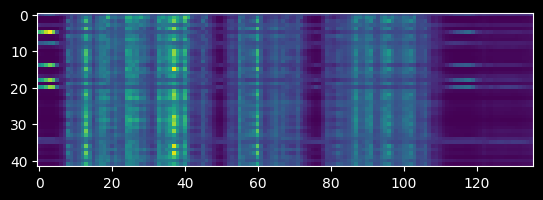

step 61: loss 3.512
step 62: loss 3.681
step 63: loss 3.382
step 64: loss 3.585
step 65: loss 3.517
step 66: loss 3.544
step 67: loss 3.553
step 68: loss 3.388
step 69: loss 3.479
step 70: loss 3.464
step 71: loss 3.382
step 72: loss 3.422
step 73: loss 3.447
step 74: loss 3.479
step 75: loss 3.458
step 76: loss 3.380
step 77: loss 3.292
step 78: loss 3.516
step 79: loss 3.356
step 80: loss 3.481


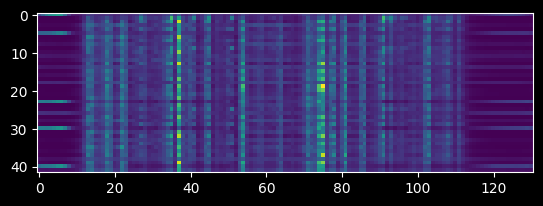

step 81: loss 3.434
step 82: loss 3.399
step 83: loss 3.254
step 84: loss 3.353
step 85: loss 3.419
step 86: loss 3.171
step 87: loss 3.347
step 88: loss 3.236
step 89: loss 3.334
step 90: loss 3.229
step 91: loss 3.322
step 92: loss 3.196
step 93: loss 3.282
step 94: loss 3.475
step 95: loss 3.399
step 96: loss 3.368
step 97: loss 3.249
step 98: loss 3.120
step 99: loss 3.314
step 100: loss 3.282


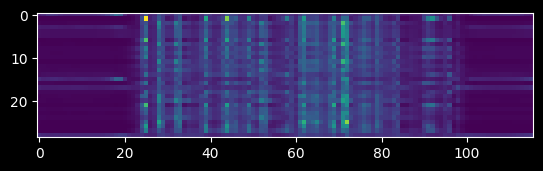

step 101: loss 3.317
step 102: loss 3.263
step 103: loss 3.091
step 104: loss 3.507
step 105: loss 3.318
step 106: loss 3.346
step 107: loss 3.117
step 108: loss 3.295
step 109: loss 3.283
step 110: loss 3.395
step 111: loss 3.256
step 112: loss 3.295
step 113: loss 3.251
step 114: loss 3.402
step 115: loss 3.289
step 116: loss 3.271
step 117: loss 3.291
step 118: loss 3.277
step 119: loss 3.345
step 120: loss 3.131


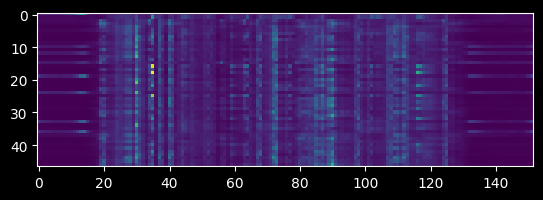

step 121: loss 3.178
step 122: loss 3.191
step 123: loss 3.341
step 124: loss 3.138
step 125: loss 3.181
step 126: loss 3.233
step 127: loss 3.171
step 128: loss 3.147
step 129: loss 3.149
step 130: loss 3.132
step 131: loss 3.115
step 132: loss 3.169
step 133: loss 3.332
step 134: loss 3.300
step 135: loss 3.089
step 136: loss 3.240
step 137: loss 3.088
step 138: loss 3.212
step 139: loss 3.081
step 140: loss 3.125


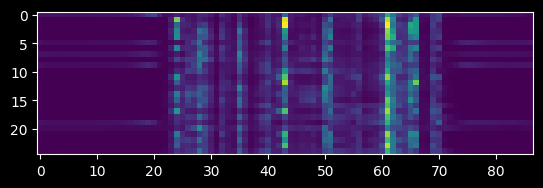

step 141: loss 3.258
step 142: loss 3.198
step 143: loss 3.193
step 144: loss 3.136
step 145: loss 3.149
step 146: loss 3.162
step 147: loss 3.130
step 148: loss 3.098
step 149: loss 3.198
step 150: loss 3.259
step 151: loss 3.084
step 152: loss 3.110
step 153: loss 3.024
step 154: loss 3.256
step 155: loss 3.218
step 156: loss 3.256
step 157: loss 3.087
step 158: loss 3.127
step 159: loss 3.146
step 160: loss 3.202


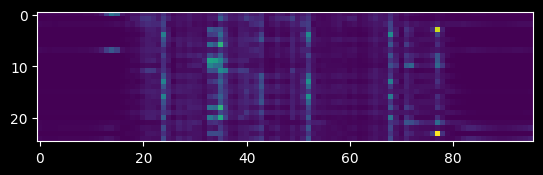

step 161: loss 3.031
step 162: loss 3.178
step 163: loss 3.242
step 164: loss 3.083
step 165: loss 3.167
step 166: loss 3.051
step 167: loss 3.123
step 168: loss 2.975
step 169: loss 3.169
step 170: loss 2.962
step 171: loss 3.159
step 172: loss 3.180
step 173: loss 3.196
step 174: loss 3.002
step 175: loss 3.035
step 176: loss 3.104
step 177: loss 3.085
step 178: loss 3.111
step 179: loss 3.219
step 180: loss 3.269


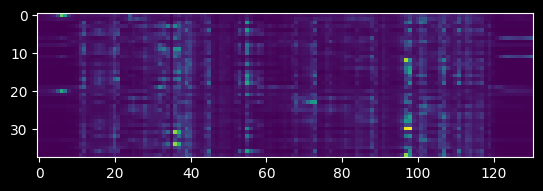

step 181: loss 3.200
step 182: loss 3.055
step 183: loss 2.918
step 184: loss 3.050
step 185: loss 2.967
step 186: loss 3.124
step 187: loss 3.020
step 188: loss 3.067
step 189: loss 2.827
step 190: loss 2.965
step 191: loss 3.032
step 192: loss 3.004
step 193: loss 3.053
step 194: loss 3.187
step 195: loss 2.968
step 196: loss 3.225
step 197: loss 2.981
step 198: loss 3.090
step 199: loss 3.124
step 200: loss 2.973


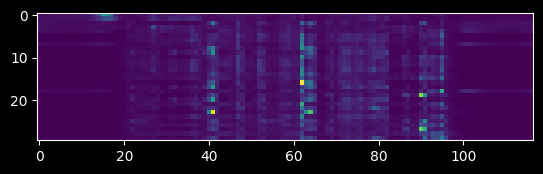

step 201: loss 3.040
step 202: loss 2.939
step 203: loss 3.235
step 204: loss 3.151
step 205: loss 3.168
step 206: loss 2.993
step 207: loss 2.922
step 208: loss 2.932
step 209: loss 2.997
step 210: loss 3.045
step 211: loss 2.840
step 212: loss 2.900
step 213: loss 2.938
step 214: loss 2.954
step 215: loss 2.865
step 216: loss 2.993
step 217: loss 2.857
step 218: loss 3.025
step 219: loss 2.955
step 220: loss 3.082


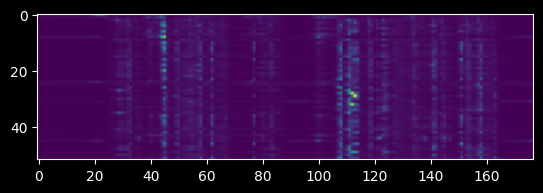

step 221: loss 3.097
step 222: loss 2.825
step 223: loss 3.086
step 224: loss 2.929
step 225: loss 3.049
step 226: loss 3.081
step 227: loss 2.960
step 228: loss 3.133
step 1: loss 3.011
step 2: loss 3.048
step 3: loss 3.091
step 4: loss 3.004
step 5: loss 2.978
step 6: loss 2.726
step 7: loss 2.651
step 8: loss 2.827
step 9: loss 2.653
step 10: loss 2.794
step 11: loss 2.821
step 12: loss 2.881
step 13: loss 2.740
step 14: loss 2.748
step 15: loss 2.832
step 16: loss 2.842
step 17: loss 2.917
step 18: loss 2.886
step 19: loss 3.079
step 20: loss 2.913


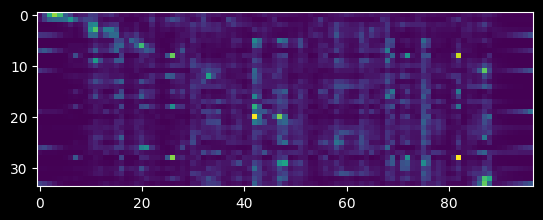

step 21: loss 2.730
step 22: loss 2.926
step 23: loss 3.035
step 24: loss 2.911
step 25: loss 2.805
step 26: loss 2.740
step 27: loss 2.809
step 28: loss 2.907
step 29: loss 3.108
step 30: loss 2.795
step 31: loss 2.766
step 32: loss 2.925
step 33: loss 2.841
step 34: loss 2.709
step 35: loss 2.774
step 36: loss 2.835
step 37: loss 2.814
step 38: loss 2.755
step 39: loss 2.726
step 40: loss 2.665


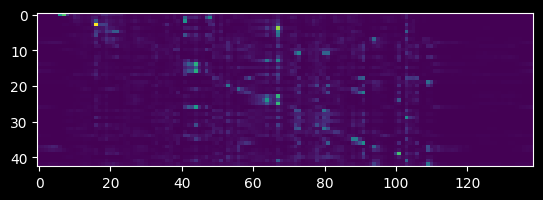

step 41: loss 2.883
step 42: loss 2.950
step 43: loss 2.846
step 44: loss 2.705
step 45: loss 2.842
step 46: loss 2.892
step 47: loss 2.814
step 48: loss 2.867
step 49: loss 2.729
step 50: loss 2.865
step 51: loss 2.785
step 52: loss 2.787
step 53: loss 2.821
step 54: loss 2.877
step 55: loss 2.775
step 56: loss 2.803
step 57: loss 2.722
step 58: loss 2.599
step 59: loss 2.720
step 60: loss 2.694


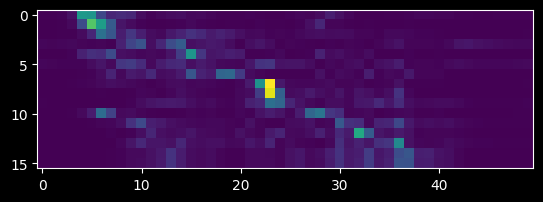

step 61: loss 2.727
step 62: loss 2.835
step 63: loss 2.682
step 64: loss 2.816
step 65: loss 2.693
step 66: loss 2.776
step 67: loss 2.755
step 68: loss 2.782
step 69: loss 2.811
step 70: loss 2.864
step 71: loss 2.622
step 72: loss 2.547
step 73: loss 2.701
step 74: loss 2.764
step 75: loss 2.718
step 76: loss 2.615
step 77: loss 2.761
step 78: loss 2.727
step 79: loss 2.605
step 80: loss 2.358


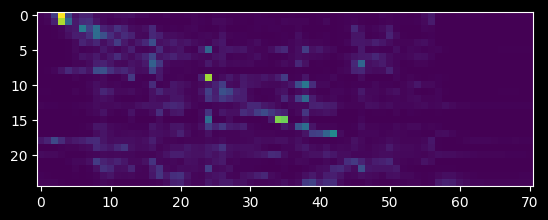

step 81: loss 2.529
step 82: loss 2.681
step 83: loss 2.786
step 84: loss 2.556
step 85: loss 2.683
step 86: loss 2.609
step 87: loss 2.599
step 88: loss 2.567
step 89: loss 2.463
step 90: loss 2.733
step 91: loss 2.566
step 92: loss 2.856
step 93: loss 2.644
step 94: loss 2.678
step 95: loss 2.795
step 96: loss 2.688
step 97: loss 2.573
step 98: loss 2.631
step 99: loss 2.608
step 100: loss 2.693


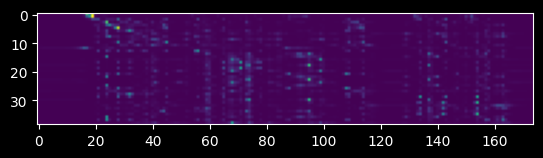

step 101: loss 2.890
step 102: loss 2.656
step 103: loss 2.708
step 104: loss 2.596
step 105: loss 2.754
step 106: loss 2.656
step 107: loss 2.531
step 108: loss 2.563
step 109: loss 2.603
step 110: loss 2.496
step 111: loss 2.710
step 112: loss 2.415
step 113: loss 2.668
step 114: loss 2.605
step 115: loss 2.547
step 116: loss 2.659
step 117: loss 2.675
step 118: loss 2.630
step 119: loss 2.492
step 120: loss 2.376


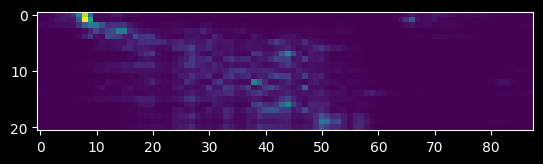

step 121: loss 2.679
step 122: loss 2.538
step 123: loss 2.462
step 124: loss 2.420
step 125: loss 2.668
step 126: loss 2.459
step 127: loss 2.369
step 128: loss 2.551
step 129: loss 2.676
step 130: loss 2.631
step 131: loss 2.534
step 132: loss 2.759
step 133: loss 2.550
step 134: loss 2.550
step 135: loss 2.562
step 136: loss 2.463
step 137: loss 2.627
step 138: loss 2.488
step 139: loss 2.667
step 140: loss 2.651


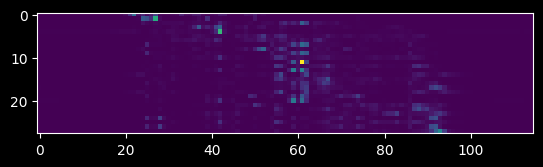

step 141: loss 2.416
step 142: loss 2.606
step 143: loss 2.637
step 144: loss 2.642
step 145: loss 2.558
step 146: loss 2.502
step 147: loss 2.374
step 148: loss 2.473
step 149: loss 2.541
step 150: loss 2.423
step 151: loss 2.590
step 152: loss 2.500
step 153: loss 2.527
step 154: loss 2.691
step 155: loss 2.719
step 156: loss 2.366
step 157: loss 2.347
step 158: loss 2.478
step 159: loss 2.309
step 160: loss 2.444


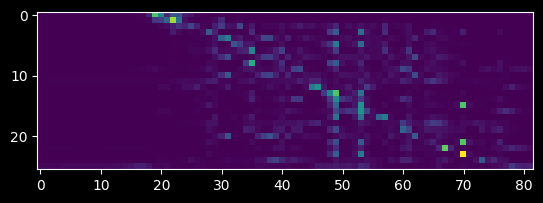

step 161: loss 2.497
step 162: loss 2.276
step 163: loss 2.697
step 164: loss 2.439
step 165: loss 2.567
step 166: loss 2.266
step 167: loss 2.450
step 168: loss 2.508
step 169: loss 2.370
step 170: loss 2.462
step 171: loss 2.453
step 172: loss 2.499
step 173: loss 2.427
step 174: loss 2.464
step 175: loss 2.460
step 176: loss 2.348
step 177: loss 2.460
step 178: loss 2.502
step 179: loss 2.350
step 180: loss 2.532


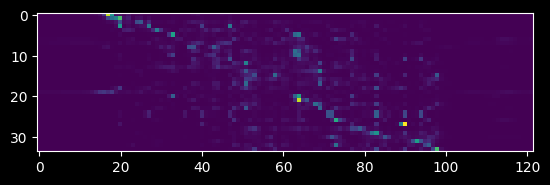

step 181: loss 2.467
step 182: loss 2.285
step 183: loss 2.305
step 184: loss 2.309
step 185: loss 2.374
step 186: loss 2.378
step 187: loss 2.295
step 188: loss 2.282
step 189: loss 2.443
step 190: loss 2.274
step 191: loss 2.389
step 192: loss 2.332
step 193: loss 2.248
step 194: loss 2.424
step 195: loss 2.342
step 196: loss 2.291
step 197: loss 2.488
step 198: loss 2.282
step 199: loss 2.176
step 200: loss 2.235


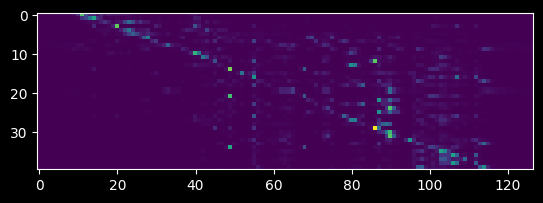

step 201: loss 2.505
step 202: loss 2.443
step 203: loss 2.512
step 204: loss 2.302
step 205: loss 2.291
step 206: loss 2.328
step 207: loss 2.260
step 208: loss 2.222
step 209: loss 2.269
step 210: loss 2.349
step 211: loss 2.339
step 212: loss 2.213
step 213: loss 2.154
step 214: loss 2.345
step 215: loss 2.387
step 216: loss 2.443
step 217: loss 2.275
step 218: loss 2.434
step 219: loss 2.359
step 220: loss 2.406


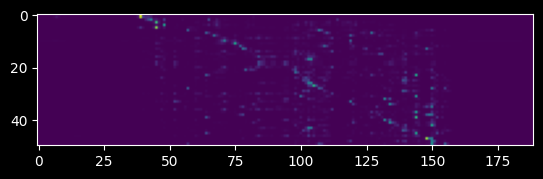

step 221: loss 2.378
step 222: loss 2.363
step 223: loss 2.180
step 224: loss 2.187
step 225: loss 2.255
step 226: loss 2.113
step 227: loss 2.361
step 228: loss 2.430
step 1: loss 2.140
step 2: loss 2.207
step 3: loss 2.089
step 4: loss 2.320
step 5: loss 2.274
step 6: loss 2.153
step 7: loss 2.267
step 8: loss 2.142
step 9: loss 2.201
step 10: loss 2.292
step 11: loss 2.116
step 12: loss 2.039
step 13: loss 2.182
step 14: loss 2.102
step 15: loss 2.230
step 16: loss 2.247
step 17: loss 1.918
step 18: loss 2.085
step 19: loss 2.131
step 20: loss 2.297


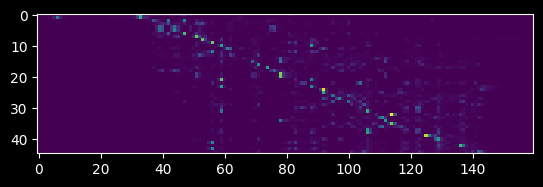

step 21: loss 2.252
step 22: loss 2.160
step 23: loss 2.099
step 24: loss 2.246
step 25: loss 2.292
step 26: loss 2.096
step 27: loss 1.865
step 28: loss 2.118
step 29: loss 2.026
step 30: loss 2.027
step 31: loss 2.152
step 32: loss 2.070
step 33: loss 2.228
step 34: loss 2.112
step 35: loss 2.141
step 36: loss 2.383
step 37: loss 2.101
step 38: loss 2.239
step 39: loss 2.062
step 40: loss 1.981


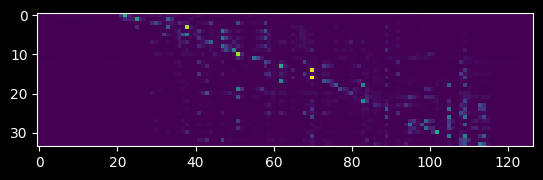

step 41: loss 2.188
step 42: loss 2.107
step 43: loss 1.994
step 44: loss 1.958
step 45: loss 1.963
step 46: loss 1.996
step 47: loss 2.267
step 48: loss 2.121
step 49: loss 2.151
step 50: loss 1.842
step 51: loss 1.912
step 52: loss 2.087
step 53: loss 2.193
step 54: loss 2.206
step 55: loss 2.186
step 56: loss 2.050
step 57: loss 2.288
step 58: loss 2.182
step 59: loss 2.109
step 60: loss 1.859


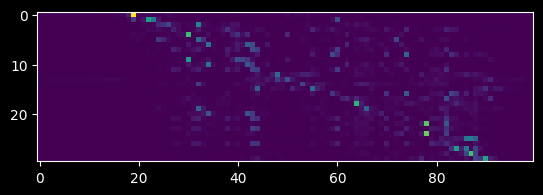

step 61: loss 2.076
step 62: loss 2.294
step 63: loss 1.913
step 64: loss 2.161
step 65: loss 1.903
step 66: loss 2.100
step 67: loss 2.000
step 68: loss 2.199
step 69: loss 2.065
step 70: loss 1.879
step 71: loss 1.909
step 72: loss 2.157
step 73: loss 2.170
step 74: loss 2.065
step 75: loss 2.072
step 76: loss 2.016
step 77: loss 1.978
step 78: loss 2.114
step 79: loss 1.957
step 80: loss 2.102


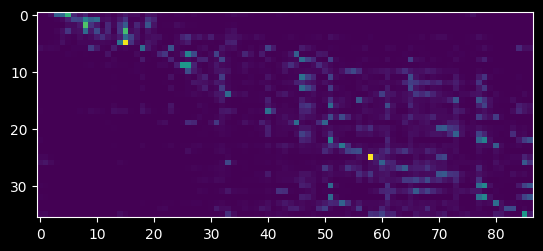

step 81: loss 2.084
step 82: loss 2.145
step 83: loss 1.992
step 84: loss 2.195
step 85: loss 2.076
step 86: loss 2.145
step 87: loss 2.159
step 88: loss 2.214
step 89: loss 2.087
step 90: loss 1.890
step 91: loss 1.942
step 92: loss 2.021
step 93: loss 2.217
step 94: loss 1.944
step 95: loss 2.188
step 96: loss 1.941
step 97: loss 1.914
step 98: loss 2.079
step 99: loss 2.091
step 100: loss 2.060


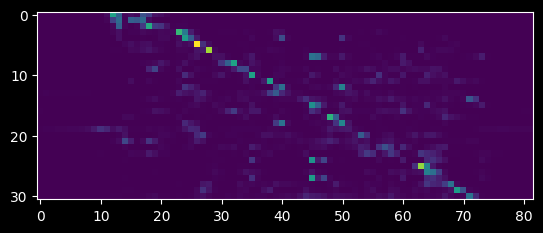

step 101: loss 2.171
step 102: loss 1.931
step 103: loss 1.988
step 104: loss 2.331
step 105: loss 2.004
step 106: loss 2.048
step 107: loss 2.071
step 108: loss 2.010
step 109: loss 1.997
step 110: loss 1.826
step 111: loss 2.096
step 112: loss 2.326
step 113: loss 2.180
step 114: loss 2.208
step 115: loss 1.719
step 116: loss 2.194
step 117: loss 2.390
step 118: loss 1.684
step 119: loss 1.960
step 120: loss 2.048


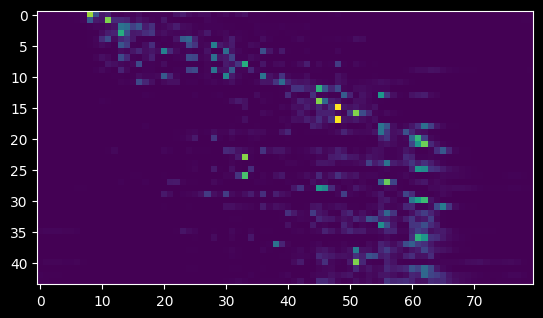

step 121: loss 1.865
step 122: loss 2.038
step 123: loss 1.870
step 124: loss 1.982
step 125: loss 1.870
step 126: loss 1.947
step 127: loss 2.005
step 128: loss 1.900
step 129: loss 1.953
step 130: loss 2.067
step 131: loss 2.077
step 132: loss 1.959
step 133: loss 2.032
step 134: loss 1.970
step 135: loss 2.048
step 136: loss 1.814
step 137: loss 2.057
step 138: loss 2.082
step 139: loss 1.824
step 140: loss 2.219


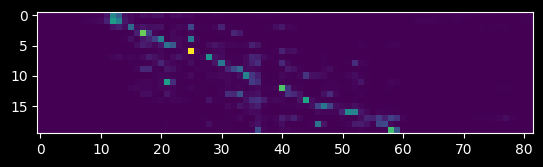

step 141: loss 2.021
step 142: loss 1.830
step 143: loss 1.917
step 144: loss 2.134
step 145: loss 1.732
step 146: loss 1.957
step 147: loss 1.712
step 148: loss 1.886
step 149: loss 1.758
step 150: loss 1.901
step 151: loss 2.033
step 152: loss 2.024
step 153: loss 1.942
step 154: loss 1.729
step 155: loss 1.951
step 156: loss 1.905
step 157: loss 2.097
step 158: loss 1.916
step 159: loss 2.072
step 160: loss 1.867


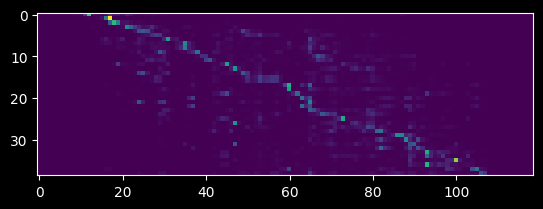

step 161: loss 2.089
step 162: loss 1.957
step 163: loss 2.010
step 164: loss 1.957
step 165: loss 2.126
step 166: loss 2.034
step 167: loss 1.753
step 168: loss 2.081
step 169: loss 2.075
step 170: loss 1.728
step 171: loss 1.885
step 172: loss 1.978
step 173: loss 1.843
step 174: loss 2.023
step 175: loss 2.130
step 176: loss 1.784
step 177: loss 1.887
step 178: loss 1.931
step 179: loss 1.811
step 180: loss 1.919


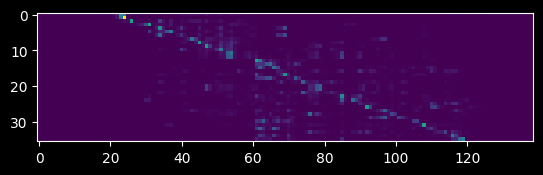

step 181: loss 2.055
step 182: loss 1.879
step 183: loss 1.802
step 184: loss 1.869
step 185: loss 1.986
step 186: loss 1.734
step 187: loss 1.951
step 188: loss 2.075
step 189: loss 1.962
step 190: loss 2.037
step 191: loss 2.008
step 192: loss 1.788
step 193: loss 2.144
step 194: loss 1.791
step 195: loss 2.142
step 196: loss 2.098
step 197: loss 2.019
step 198: loss 1.950
step 199: loss 2.086
step 200: loss 1.800


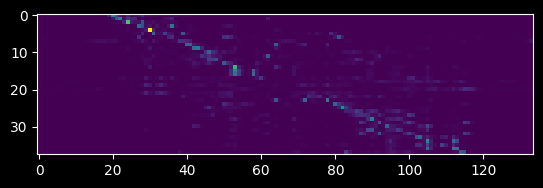

step 201: loss 1.841
step 202: loss 1.885
step 203: loss 2.071
step 204: loss 1.977
step 205: loss 1.933
step 206: loss 2.059
step 207: loss 1.815
step 208: loss 1.956
step 209: loss 1.849
step 210: loss 2.051
step 211: loss 2.052
step 212: loss 1.876
step 213: loss 2.011
step 214: loss 2.028
step 215: loss 1.802
step 216: loss 1.734
step 217: loss 1.706
step 218: loss 1.672
step 219: loss 1.663
step 220: loss 1.890


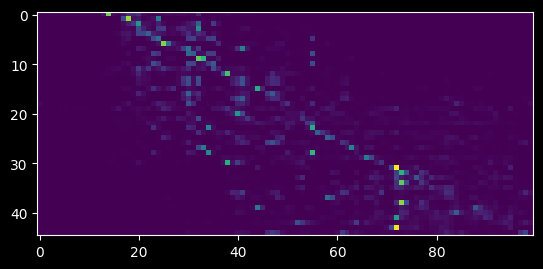

step 221: loss 2.054
step 222: loss 1.771
step 223: loss 1.981
step 224: loss 1.939
step 225: loss 1.914
step 226: loss 2.023
step 227: loss 2.092
step 228: loss 2.072


In [ ]:
DEVICE = "cuda"

conf = {
    "encoder": {
        "name": "v2_ctc",
        "d_model": 768,
    },
    "decoder": {
        "d_model": 128,
        "n_heads": 4,
        "embedding_dim": 128,
        "n_layers": 2,
        "tokenizer_path": "./spm_ky.model",
    },
}

model = EncoderDecoder(conf).to(DEVICE)

dec_params = list(model.decoder.parameters()) + list(model.projector.parameters())

for p in model.encoder.parameters():
    p.requires_grad = False
model.encoder.eval()

opt = torch.optim.AdamW(dec_params, lr=1e-3)

N_EPOCHS = 3

model.train()
for _ in range(N_EPOCHS):
    for step, batch in enumerate(loader, 1):
        feats, flens, tgts, tlens = [x.to(DEVICE) for x in batch]
        loss = model(feats, flens, tgts, tlens)
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(f"step {step}: loss {loss.item():.3f}")

        if step % 20 == 0:
            model.eval()
            with torch.no_grad():
                feats1, flens1, tgts1, tlens1 = (
                    feats[:1],
                    flens[:1],
                    tgts[:1],
                    tlens[:1],
                )

                feats_len_real = int(flens1.item())
                feats_in = feats1[:, :, :feats_len_real]
                tgt_len_real = int(tlens1.item())
                tgt_in = tgts1[:, :tgt_len_real]

                logits, attns = model.forward(
                    feats_in,
                    torch.tensor([feats_len_real], device=DEVICE),
                    tgt_in,
                    torch.tensor([tgt_len_real], device=DEVICE),
                    return_attn=True,
                )

                attn_last = attns[-1][0]
                plt.imshow(attn_last.cpu())
                plt.show()

            model.train()

[B] step 1: loss 1.683
[B] step 2: loss 1.691
[B] step 3: loss 1.649
[B] step 4: loss 1.832
[B] step 5: loss 1.593
[B] step 6: loss 1.746
[B] step 7: loss 1.801
[B] step 8: loss 1.896
[B] step 9: loss 1.745
[B] step 10: loss 1.611
[B] step 11: loss 1.716
[B] step 12: loss 1.754
[B] step 13: loss 1.443
[B] step 14: loss 1.807
[B] step 15: loss 1.837
[B] step 16: loss 1.501
[B] step 17: loss 1.318
[B] step 18: loss 1.693
[B] step 19: loss 1.370
[B] step 20: loss 1.446


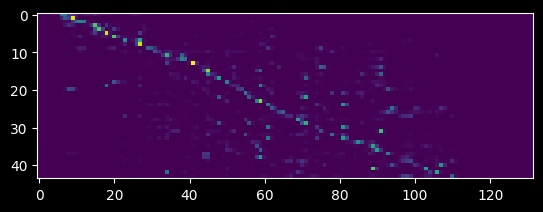

[B] step 21: loss 1.458
[B] step 22: loss 1.532
[B] step 23: loss 1.692
[B] step 24: loss 1.679
[B] step 25: loss 1.472
[B] step 26: loss 1.492
[B] step 27: loss 1.392
[B] step 28: loss 1.419
[B] step 29: loss 1.803
[B] step 30: loss 1.436
[B] step 31: loss 1.523
[B] step 32: loss 1.499
[B] step 33: loss 1.495
[B] step 34: loss 1.524
[B] step 35: loss 1.573
[B] step 36: loss 1.355
[B] step 37: loss 1.434
[B] step 38: loss 1.386
[B] step 39: loss 1.205
[B] step 40: loss 1.157


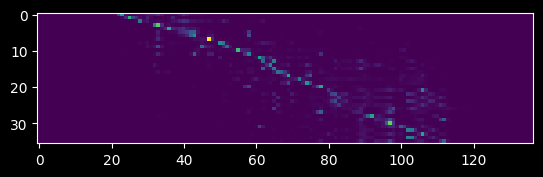

[B] step 41: loss 1.354
[B] step 42: loss 1.548
[B] step 43: loss 1.458
[B] step 44: loss 1.241
[B] step 45: loss 1.631
[B] step 46: loss 1.400
[B] step 47: loss 1.228
[B] step 48: loss 1.372
[B] step 49: loss 1.404
[B] step 50: loss 1.539
[B] step 51: loss 1.593
[B] step 52: loss 1.342
[B] step 53: loss 1.212
[B] step 54: loss 1.331
[B] step 55: loss 1.412
[B] step 56: loss 1.421
[B] step 57: loss 1.674
[B] step 58: loss 1.271
[B] step 59: loss 1.248
[B] step 60: loss 1.228


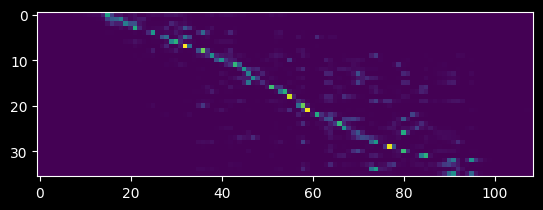

[B] step 61: loss 1.168
[B] step 62: loss 1.286
[B] step 63: loss 1.271
[B] step 64: loss 1.575
[B] step 65: loss 1.298
[B] step 66: loss 1.231
[B] step 67: loss 1.288
[B] step 68: loss 1.391
[B] step 69: loss 1.404
[B] step 70: loss 1.462
[B] step 71: loss 1.643
[B] step 72: loss 1.304
[B] step 73: loss 1.288
[B] step 74: loss 1.247
[B] step 75: loss 1.171
[B] step 76: loss 1.423
[B] step 77: loss 1.473
[B] step 78: loss 1.135
[B] step 79: loss 1.401
[B] step 80: loss 1.312


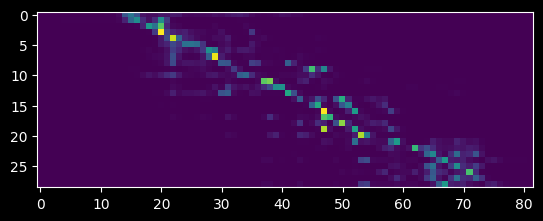

[B] step 81: loss 0.934
[B] step 82: loss 1.323
[B] step 83: loss 1.461
[B] step 84: loss 1.219
[B] step 85: loss 1.283
[B] step 86: loss 1.385
[B] step 87: loss 1.003
[B] step 88: loss 1.407
[B] step 89: loss 1.224
[B] step 90: loss 1.342
[B] step 91: loss 1.293
[B] step 92: loss 1.337
[B] step 93: loss 1.238
[B] step 94: loss 1.294
[B] step 95: loss 1.356
[B] step 96: loss 1.166
[B] step 97: loss 1.211
[B] step 98: loss 1.201
[B] step 99: loss 1.040
[B] step 100: loss 1.270


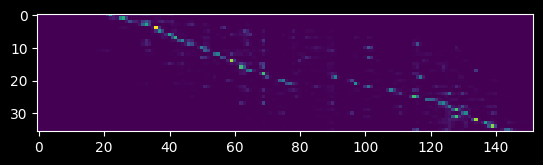

[B] step 101: loss 1.441
[B] step 102: loss 1.116
[B] step 103: loss 1.099
[B] step 104: loss 1.235
[B] step 105: loss 1.321
[B] step 106: loss 1.174
[B] step 107: loss 1.002
[B] step 108: loss 1.177
[B] step 109: loss 1.230
[B] step 110: loss 1.207
[B] step 111: loss 1.167
[B] step 112: loss 1.295
[B] step 113: loss 1.298
[B] step 114: loss 1.351
[B] step 115: loss 1.340
[B] step 116: loss 1.154
[B] step 117: loss 1.161
[B] step 118: loss 1.132
[B] step 119: loss 1.336
[B] step 120: loss 1.207


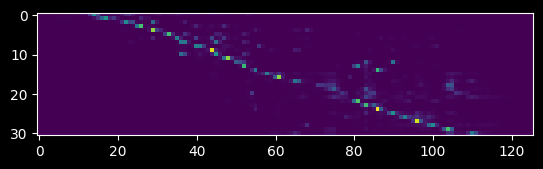

[B] step 121: loss 1.079
[B] step 122: loss 1.431
[B] step 123: loss 1.010
[B] step 124: loss 1.259
[B] step 125: loss 1.054
[B] step 126: loss 1.166
[B] step 127: loss 1.054
[B] step 128: loss 1.201
[B] step 129: loss 1.064
[B] step 130: loss 1.250
[B] step 131: loss 1.255
[B] step 132: loss 1.329
[B] step 133: loss 1.089
[B] step 134: loss 1.006
[B] step 135: loss 1.068
[B] step 136: loss 1.052
[B] step 137: loss 1.010
[B] step 138: loss 0.937
[B] step 139: loss 0.917
[B] step 140: loss 1.210


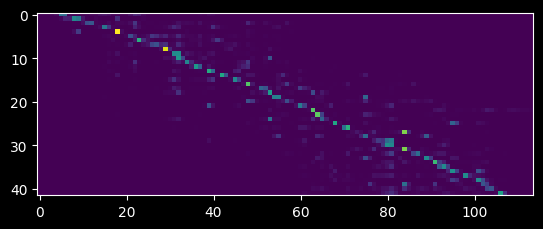

[B] step 141: loss 1.155
[B] step 142: loss 1.330
[B] step 143: loss 1.390
[B] step 144: loss 1.066
[B] step 145: loss 1.188
[B] step 146: loss 1.063
[B] step 147: loss 0.934
[B] step 148: loss 1.223
[B] step 149: loss 0.969
[B] step 150: loss 1.052
[B] step 151: loss 1.195
[B] step 152: loss 0.934
[B] step 153: loss 1.075
[B] step 154: loss 0.924
[B] step 155: loss 1.412
[B] step 156: loss 1.123
[B] step 157: loss 1.128
[B] step 158: loss 1.120
[B] step 159: loss 0.897
[B] step 160: loss 1.036


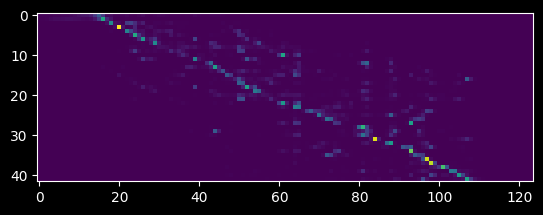

[B] step 161: loss 0.988
[B] step 162: loss 1.529
[B] step 163: loss 1.232
[B] step 164: loss 1.172
[B] step 165: loss 1.168
[B] step 166: loss 1.050
[B] step 167: loss 1.003
[B] step 168: loss 0.972
[B] step 169: loss 1.127
[B] step 170: loss 1.191
[B] step 171: loss 1.640
[B] step 172: loss 1.122
[B] step 173: loss 1.164
[B] step 174: loss 1.184
[B] step 175: loss 1.299
[B] step 176: loss 1.147
[B] step 177: loss 1.200
[B] step 178: loss 1.094
[B] step 179: loss 1.412
[B] step 180: loss 1.097


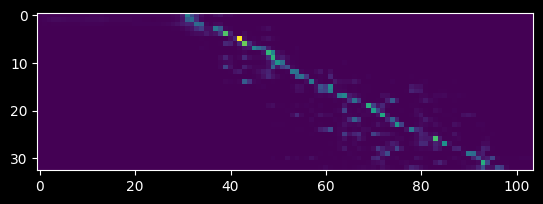

[B] step 181: loss 1.024
[B] step 182: loss 0.917
[B] step 183: loss 1.210
[B] step 184: loss 1.065
[B] step 185: loss 1.113
[B] step 186: loss 0.859
[B] step 187: loss 1.076
[B] step 188: loss 1.145
[B] step 189: loss 1.107
[B] step 190: loss 0.857
[B] step 191: loss 1.331
[B] step 192: loss 1.066
[B] step 193: loss 0.905
[B] step 194: loss 1.373
[B] step 195: loss 1.244
[B] step 196: loss 0.987
[B] step 197: loss 1.010
[B] step 198: loss 1.203
[B] step 199: loss 0.836
[B] step 200: loss 0.959


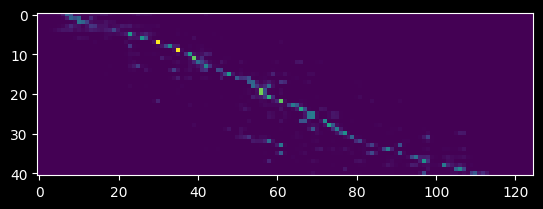

[B] step 201: loss 0.846
[B] step 202: loss 1.195
[B] step 203: loss 1.264
[B] step 204: loss 1.062
[B] step 205: loss 0.880
[B] step 206: loss 1.101
[B] step 207: loss 0.949
[B] step 208: loss 0.993
[B] step 209: loss 1.067
[B] step 210: loss 1.158
[B] step 211: loss 1.086
[B] step 212: loss 0.941
[B] step 213: loss 1.052
[B] step 214: loss 0.914
[B] step 215: loss 1.116
[B] step 216: loss 1.004
[B] step 217: loss 1.063
[B] step 218: loss 1.110
[B] step 219: loss 0.953
[B] step 220: loss 1.148


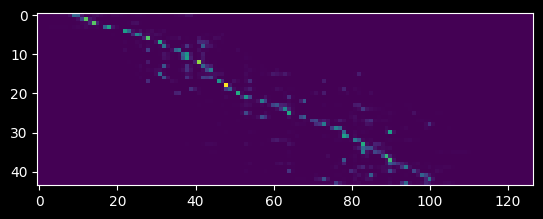

[B] step 221: loss 1.261
[B] step 222: loss 0.864
[B] step 223: loss 0.962
[B] step 224: loss 1.011
[B] step 225: loss 0.936
[B] step 226: loss 1.077
[B] step 227: loss 0.917
[B] step 228: loss 1.129


In [ ]:
for p in model.encoder.parameters():
    p.requires_grad = True
model.train()


opt = torch.optim.AdamW(
    [
        {"params": model.encoder.parameters(), "lr": 3e-4},
        {"params": dec_params, "lr": 1e-3},
    ],
    weight_decay=1e-2,
)

for step, batch in enumerate(loader, 1):
    feats, flens, tgts, tlens = [x.to(DEVICE) for x in batch]
    loss = model(feats, flens, tgts, tlens)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    print(f"step {step}: loss {loss.item():.3f}")
    if step % 20 == 0:
        model.eval()
        with torch.no_grad():
            feats1, flens1, tgts1, tlens1 = feats[:1], flens[:1], tgts[:1], tlens[:1]

            feats_len_real = int(flens1.item())
            feats_in = feats1[:, :, :feats_len_real]
            tgt_len_real = int(tlens1.item())
            tgt_in = tgts1[:, :tgt_len_real]

            logits, attns = model.forward(
                feats_in,
                torch.tensor([feats_len_real], device=DEVICE),
                tgt_in,
                torch.tensor([tgt_len_real], device=DEVICE),
                return_attn=True,
            )

            attn_last = attns[-1][0]
            plt.imshow(attn_last.cpu())
            plt.show()